In [2]:
# Import methods and modules
import os
import cv2
import random, sys
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import models
import keras.callbacks
from keras.models import load_model
from PIL import Image, ImageDraw 
import gc # garbage collector
import json
import tensorflow as tf

In [3]:
# define preparing data function
def data_process(namelist,p,num):
    Input_vehicles = []
    Output_labels = []
    assert isinstance(namelist,list)
    for i in range(len(namelist)):
        path = p + namelist[i]
        files= os.listdir(path)
        number = 0
        for file in files:
            if number == num:
                break
            number += 1
            if file != "Thumbs.db" and file !=".DS_Store" and file !='.ipynb_checkpoints':              
                im = Image.open(path+"/"+file);
                im_resized = im.resize((200,200),Image.ANTIALIAS)
                im_resized = im_resized.convert()
                data = im_resized.getdata()
                data = np.array(data)
                label = i
                if data.ndim == 2: # delete invalued images 
                    Input_vehicles.append(data)
                    Output_labels.append(label)
    return Input_vehicles, Output_labels

In [4]:
# imput data, change to array
namelist_vehicle = ['Electric','Motor home','Passenger van','Pickup Truck','School Bus','Sedan','Shuttle bus','Sport Car','Stock Car','SUV']
path1 = 'Trainadd/'
Input_vehicles, Output_labels = data_process(namelist_vehicle,path1,101)
Input_vehicles = np.array(Input_vehicles)
Output_labels = np.array(Output_labels)
Input_vehicles = Input_vehicles.reshape([-1,200,200,3])
print(Input_vehicles.shape)

(1007, 200, 200, 3)


In [5]:
# data enhancement

# get images
def get_every_image(data, i):
    im = data[i:i+1]
    im = im[0]
    return im

# moving function
def moving(im, a, size, path, class_name ,num):  
        img1 = im  
        img2 = im 
        img3 = im 
        img4 = im 
        num = str(num)
        cv2.imwrite(path + class_name + '/' + num + 'origin.png', im)
        
        img1 = np.concatenate((img1[:, a:], img1[:, :a]), axis=1)    
        cv2.imwrite(path + class_name + '/' + num + 'mov_left.png', img1)  
        img2 = np.concatenate((img2[:, size[1] - a:], img2[:, :size[1] - a]), axis=1)  # 右  
        cv2.imwrite(path + class_name + '/' + num +  'mov_right.png', img2)  
        img3 = np.concatenate((img3[a:, :], img3[:a, :]), axis=0)    
        cv2.imwrite(path + class_name + '/' + num +  'mov_up.png', img3)  
        img4 = np.concatenate((img4[size[0] - a:, :], img4[:size[0] -a, :]), axis=0)   #下  
        cv2.imwrite(path + class_name + '/' + num +  'mov_down.png', img4)  


In [6]:
# create more images
path = 'Trainadd/Data_enhancement/'
number = Input_vehicles.shape[0]/10
for i in range(len(namelist_vehicle)):
    for j in range(number):
        im = get_every_image(Input_vehicles, j+i*number)
        moving(im, 10, (200,200), path, class_name = namelist_vehicle[i] , num = j)

In [7]:
# Reload total dataset
namelist_vehicle = ['Electric','Motor home','Passenger van','Pickup Truck','School Bus','Sedan','Shuttle bus','Sport Car','Stock Car','SUV']
path2 = 'Trainadd/Data_enhancement/'
Input_vehicles, Output_labels = data_process(namelist_vehicle,path2,500)
Input_vehicles = np.array(Input_vehicles)
Output_labels = np.array(Output_labels)
Input_vehicles = Input_vehicles.reshape([-1,200,200,3])
print(Input_vehicles.shape)

(5000, 200, 200, 3)


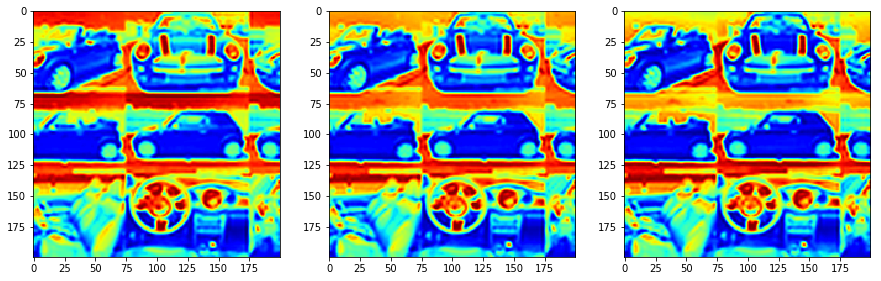

In [8]:
# Show an image example in RGB
sample = Input_vehicles[0].transpose([2,0,1])
sample_red = sample[0]
sample_green = sample[1]
sample_blue = sample[2]

plt.figure(1,figsize = (5*3,5*1))
plt.set_cmap('jet')
plt.subplot(1,3,1)
plt.imshow(sample_red)
plt.subplot(1,3,2)
plt.imshow(sample_green)
plt.subplot(1,3,3)
plt.imshow(sample_blue)



In [9]:
# prepare training data
y = np_utils.to_categorical(Output_labels,10)
indexes = np.arange(Input_vehicles.shape[0])
np.random.shuffle(indexes)
X = Input_vehicles[indexes]
y_train = y[indexes]
print(X.shape)
x_train = X/255

(5000, 200, 200, 3)


In [10]:
# release memory
del Input_vehicles
del Output_labels
gc.collect()

15

In [11]:
# Traing network
np.random.seed(21)
# network design
model = Sequential()

# 1st-stage
model.add(Conv2D(32, (3, 3),padding='valid', input_shape=(200, 200, 3), activation='relu') )
model.add(Dropout(0.5))

# 2nd-stage
model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 3rd-stage
model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 4th-stage
model.add(Conv2D(128, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 5th-stage
model.add(Conv2D(256, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# full-connected layer
model.add(Flatten())
# hidden neurons addition
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(10, activation = 'softmax'))

# optimizer
adam = Adam(lr=0.000002, decay=0.0)
model.compile(
    loss='categorical_crossentropy',
    optimizer = adam,
    metrics=['accuracy'])


In [12]:
model.save('vehicle_model.h5')
History = {'acc':[],'loss':[],'val_acc':[],'val_loss':[]}
fileObject = open('Jshistory.json', 'w')

In [6]:
fileObject = open('Jshistory.json', 'r')
History = json.load(fileObject)

In [ ]:
for num in range(40):
    model = load_model('vehicle_model.h5')  
    history = model.fit(
        x_train, 
        y_train,
        batch_size=64,
        epochs=50,
        validation_split=0.2,
        shuffle=True,
        verbose =2)
    
    History['acc'].extend(history.history['acc'])
    History['loss'].extend(history.history['loss'])
    History['val_acc'].extend(history.history['val_acc'])
    History['val_loss'].extend(history.history['val_loss'])
    Jshistory = json.dumps(History)  
    fileObject = open('Jshistory.json', 'w')
    fileObject.write(Jshistory)  
    fileObject.close()  
    model.save('vehicle_model.h5')



Train on 4000 samples, validate on 1000 samples
Epoch 1/50
 - 27s - loss: 2.3222 - acc: 0.1130 - val_loss: 2.3010 - val_acc: 0.1060
Epoch 2/50
 - 22s - loss: 2.3263 - acc: 0.1070 - val_loss: 2.3002 - val_acc: 0.1160
Epoch 3/50
 - 22s - loss: 2.3148 - acc: 0.1255 - val_loss: 2.2996 - val_acc: 0.1270
Epoch 4/50
 - 22s - loss: 2.3126 - acc: 0.1230 - val_loss: 2.2992 - val_acc: 0.1400
Epoch 5/50
 - 22s - loss: 2.3059 - acc: 0.1300 - val_loss: 2.2987 - val_acc: 0.1420
Epoch 6/50
 - 22s - loss: 2.2902 - acc: 0.1278 - val_loss: 2.2985 - val_acc: 0.1390
Epoch 7/50
 - 22s - loss: 2.2880 - acc: 0.1365 - val_loss: 2.2982 - val_acc: 0.1410
Epoch 8/50
 - 21s - loss: 2.2940 - acc: 0.1330 - val_loss: 2.2980 - val_acc: 0.1420
Epoch 9/50
 - 21s - loss: 2.2867 - acc: 0.1363 - val_loss: 2.2978 - val_acc: 0.1390
Epoch 10/50
 - 21s - loss: 2.2843 - acc: 0.1335 - val_loss: 2.2976 - val_acc: 0.1440
Epoch 11/50
 - 21s - loss: 2.2795 - acc: 0.1432 - val_loss: 2.2974 - val_acc: 0.1420
Epoch 12/50
 - 21s - loss:

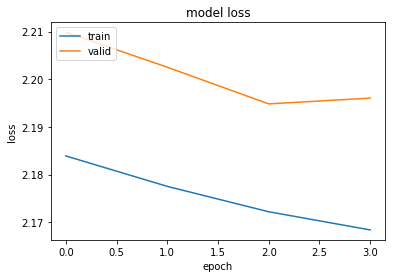

In [26]:
# Plot Loss Curve
plt.plot(History['loss'])
plt.plot(History['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

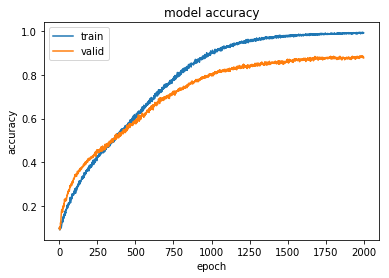

In [11]:
# Plot Accuracy Curve
plt.plot(History['acc'])
plt.plot(History['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

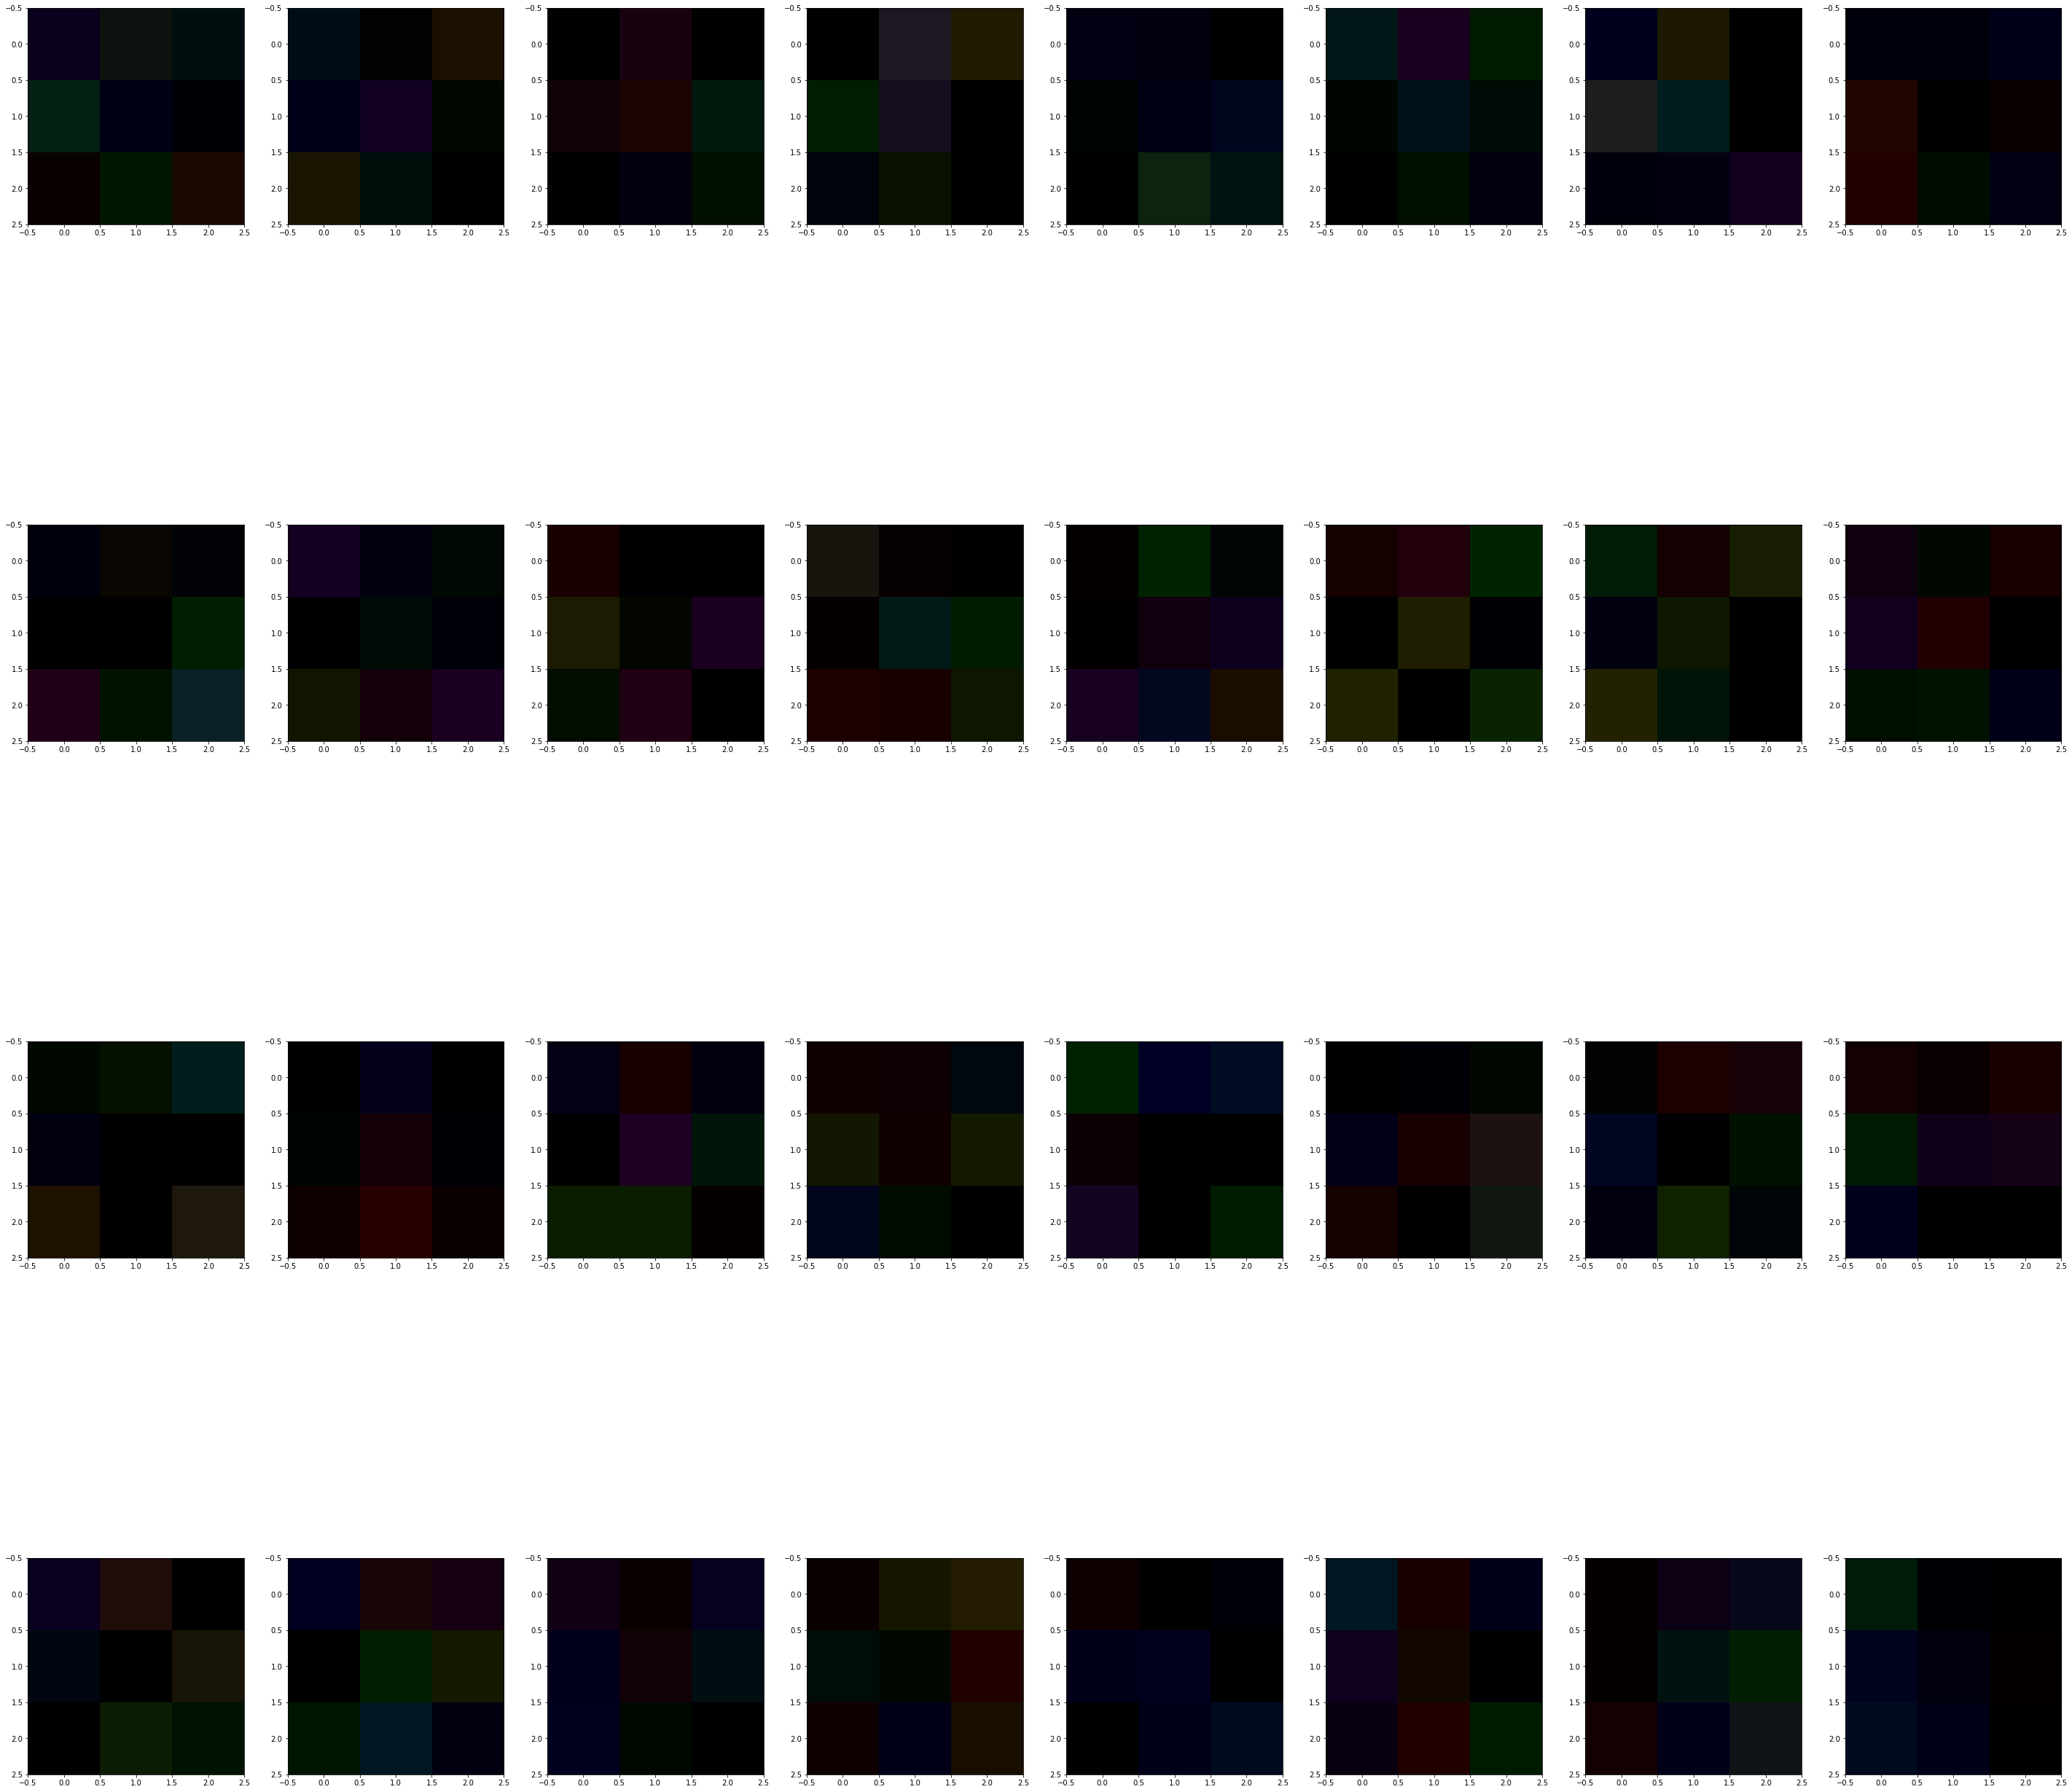

In [12]:
# filter visualization in the 1st-layer
top_layer = model.layers[0]
filter_number = 32
for i in range(filter_number):
    plt.figure(2,figsize = (10*5,10*5))
    plt.subplot(4,8,i+1)
    plt.imshow(top_layer.get_weights()[0][:, :, :, i].squeeze(), cmap='jet')

(80, 80, 3)


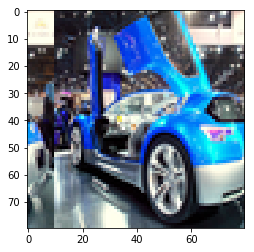

In [13]:
# visualization of all the activations in the network
# show a sample (origin)
image_sample = Input_vehicles[0:1][0]
print(image_sample.shape)
plt.imshow(image_sample)



In [14]:
# Extracts the outputs of the top 8 layers:

layer_outputs = [layer.output for layer in model.layers[:8]]
image_sample = Input_vehicles[0:1]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(image_sample)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 78, 78, 32)


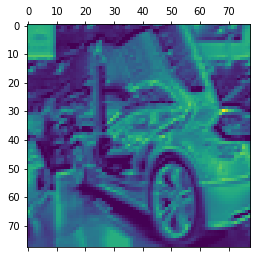

In [15]:
# visualizing the 1st channel
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()

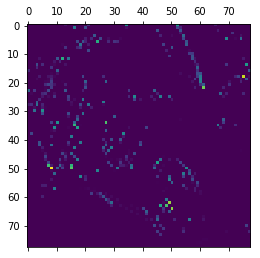

In [16]:
# visualizing the 14th channel
plt.matshow(first_layer_activation[0, :, :, 13], cmap='viridis')
plt.show()

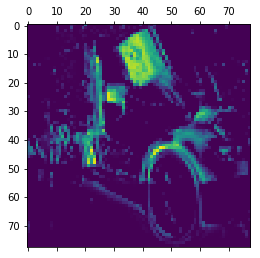

In [17]:
# visualizing the 27nd channel
plt.matshow(first_layer_activation[0, :, :, 26], cmap='viridis')
plt.show()

In [18]:
# names of the layers
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


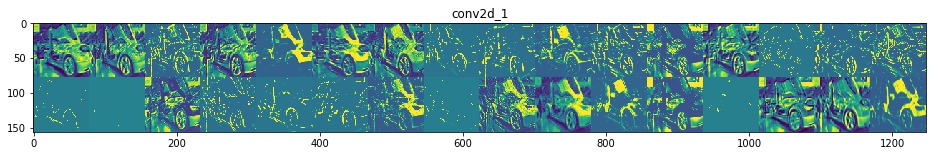

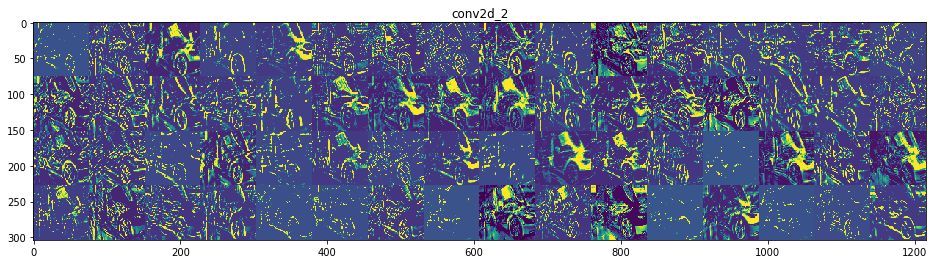

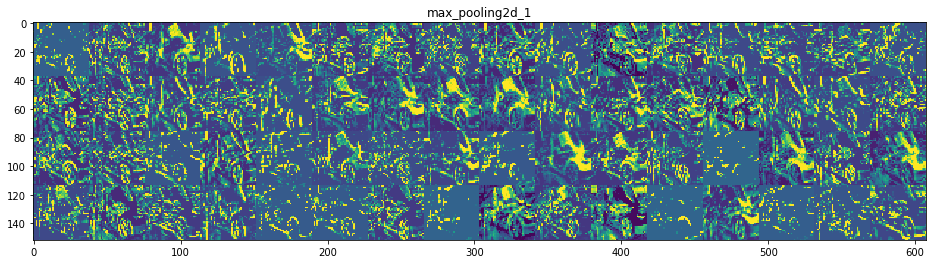

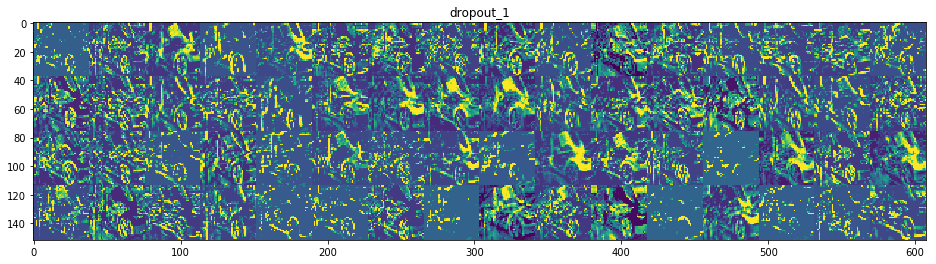

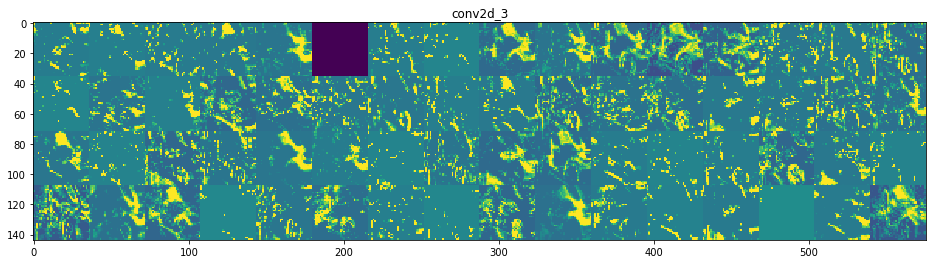

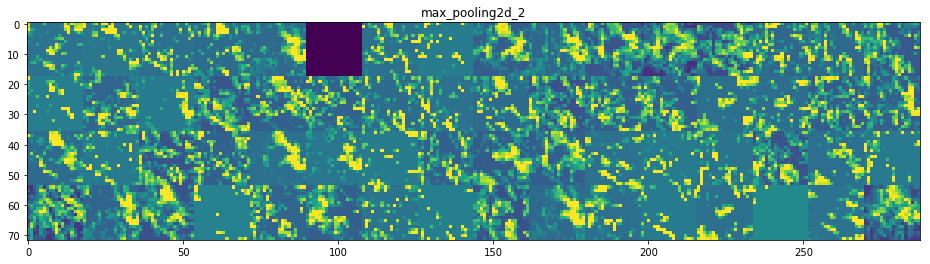

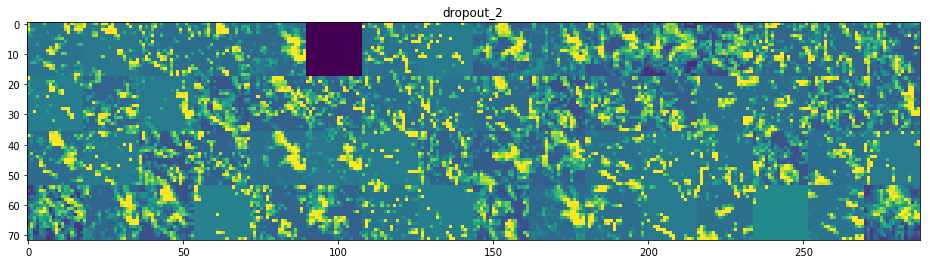

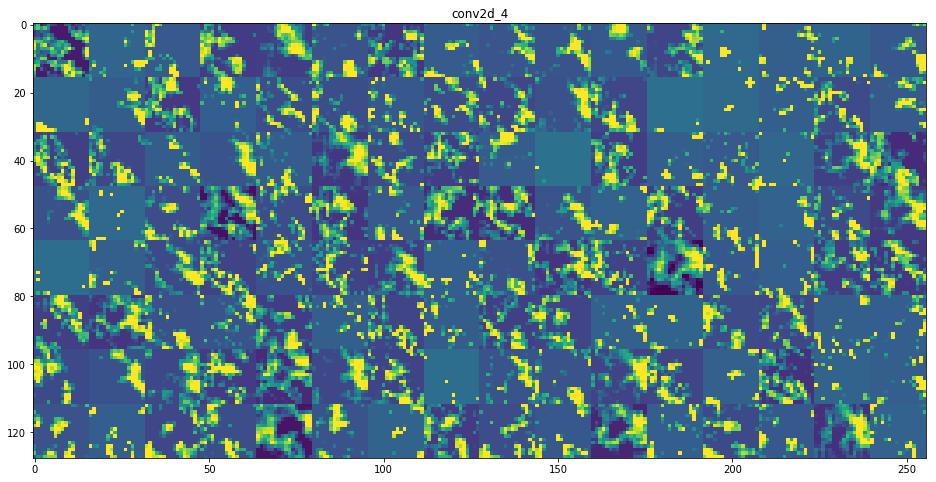

In [19]:
# Display feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # The number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
# Prediction
# load the test data
namelist_vehicle = ['Electric','Motor home','Passenger van','Pickup Truck','School Bus','Sedan','Shuttle bus','Sport Car','Stock Car','SUV']
path3 = 'Test/'
Test_vehicles, Test_labels = data_process(namelist_vehicle,path3,100)
Test_vehicles = np.array(Test_vehicles)
Test_vehicles = Test_vehicles.reshape([-1,80,80,3])
print(Test_vehicles.shape)

### define test function
def count_accuracy(outcome):
    assert isinstance(outcome,list)
    namelist_vehicle = ['Electric','Motor home','Passenger van','Pickup Truck','School Bus','Sedan','Shuttle bus','Sport Car','Stock Car','SUV']
    numbers = len(outcome)/10
    accuracy = []
    for i in range(10):
        right_number = 0
        for j in range(i*numbers,(i+1)*numbers):
            if outcome[j] == i:
                right_number += 1
        rate = namelist_vehicle[i] + ' = ' + '%.2f%%'%((float(right_number)/float(numbers)) * 100)
        accuracy.append(rate)
    return accuracy

In [ ]:
# Use model to predict
outcomes = list(model.predict_classes(Test_vehicles))
accuracy = count_accuracy(outcomes)
print(accuracy)